# Simulated Satellite Scan Strategies

In [1]:
# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    fake_focalplane
)

## Overview

A generic satellite scanning strategy can be described in terms of precession and spin axes, the opening angles about each of them, and the rates of rotation.  The precession axis itself is typically oriented in the anti-sun direction and that orientation must be updated either in steps or with a continuous slewing motion.  Here is a cartoon (drawn from an old, public LiteBIRD talk) showing a sketch of these angles:
![Cartoon of LiteBIRD scanning](litebird_scan_example.png)

For a real satellite experiment such as Planck or LiteBIRD, there are many custom details, such as simulating repointing maneuvers, simulating any lost time due to cooler cycling, nutation effects, etc.  Those are contained in classes for the specific experiments.  The tools built in to the core TOAST package are intended for rough simulations to study things like scan strategy choices.

### TOD Class for Simulations

In the introductory lesson we saw the use of a TOD derived class providing things like telescope pointing.  Here we introduce the `TODSatellite` class which serves that purpose for generic satellite simulations.

In [2]:
import numpy as np

import toast
from toast.todmap import (
    slew_precession_axis,
    TODSatellite
)

In [3]:
# Default Comm (one group for this example)

comm = toast.Comm()

In [4]:
# Create our fake focalplane

fp = fake_focalplane()

detnames = list(sorted(fp.keys()))
detquat = {x: fp[x]["quat"] for x in detnames}

In [5]:
# Scan parameters (made up, not physically motivated)

samplerate = 10.0
precperiod = 90.0
precangle = 45.0
spinperiod = 1.0
spinangle = 45.0

In [6]:
# We can simulate a simplistic HWP

hwprpm = 6.0

In [7]:
# Number of samples

nsamples = 100

In [8]:
# Instantiate a TOD

tod = TODSatellite(
    comm.comm_group, 
    detquat, 
    nsamples, 
    firstsamp=0,
    firsttime=0.0,
    rate=samplerate,
    spinperiod=spinperiod,
    spinangle=spinangle,
    precperiod=precperiod,
    precangle=precangle,
    coord="E",
    hwprpm=hwprpm
)

In [9]:
# The TOD constructor above specifies the scan parameters, but the boresight
# simulation is not done until we set the location of the precession axis as a
# function of time.  There is a reason for this delayed construction.  The data
# distribution occurs during the above construction, and we might want to only
# simulate the precession axis motion for our local data.  In reality this is
# cheap enough to do on one process and distribute during the construction.

qprec = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))

deg_per_day = 1.0

slew_precession_axis(
    qprec,
    firstsamp=tod.local_samples[0],
    samplerate=samplerate,
    degday=deg_per_day,
)

tod.set_prec_axis(qprec=qprec)

In [10]:
# Now we can read from this TOD object

print("TOD timestampes = {} ...".format(tod.read_times()[:5]))
print("TOD boresight = \n{} ...".format(tod.read_boresight()[:5,:]))
for d in detnames:
    print("TOD detector {} = {} ...".format(d, tod.read(detector=d, n=5)))
    print("TOD detector {} flags = {} ...".format(d, tod.read_flags(detector=d, n=5)))
    print("TOD detector {} pointing = {} ...".format(d, tod.read_pntg(detector=d, n=5)))

TOD timestampes = [0.  0.1 0.2 0.3 0.4] ...
TOD boresight = 
[[ 0.5         0.5        -0.5         0.5       ]
 [ 0.50372461  0.50002202 -0.49626167  0.49996385]
 [ 0.50743541  0.50002989 -0.49250974  0.49991357]
 [ 0.51113228  0.50002363 -0.4887443   0.49984914]
 [ 0.51481514  0.50000321 -0.48496547  0.49977059]] ...
TOD detector 0A = [0. 0. 0. 0. 0.] ...
TOD detector 0A flags = [0 0 0 0 0] ...
TOD detector 0A pointing = [[ 0.65328148  0.27059805 -0.27059805  0.65328148]
 [ 0.656731    0.26919305 -0.26715812  0.65181749]
 [ 0.66016234  0.26778026 -0.26371103  0.65033523]
 [ 0.66357541  0.26635974 -0.26025687  0.64883474]
 [ 0.66697012  0.26493151 -0.25679575  0.64731607]] ...
TOD detector 0B = [0. 0. 0. 0. 0.] ...
TOD detector 0B flags = [0 0 0 0 0] ...
TOD detector 0B pointing = [[ 0.65328148 -0.27059805  0.27059805  0.65328148]
 [ 0.65472717 -0.27403071  0.27199525  0.64981388]
 [ 0.65615451 -0.27745603  0.27338459  0.64632831]
 [ 0.65756345 -0.2808739   0.27476605  0.64282484]
 [ 

Notice that the signal data for all detectors is zero.  For simulated TOD classes, there is no data to "read".  Instead, simulated timestreams are constructed and stored in the `tod.cache` member variable.

### Low Resolution Example

Imagine the case of a satellite telescope with detector beams that are a 5 degrees FWHM.  We'll use a healpix resolution of NSIDE = 32 (approximately 2 degrees) for this example.  Let's use made-up angles for the spin and precession angles of 40 and 50 degrees, respectively:

\begin{align}
\alpha & = 50^{\circ}\\
\beta & = 40^{\circ}\\
\omega_{\alpha} & = \text{precession rate}\\
\omega_{\beta} & = \text{spin rate}\\
\end{align}

When computing the precession rate, we want the precession motion to be slow enough so that the speed of the boresight on the sky does not vary enough to change our effective beams.  The speed variation on the sky due to precession is

\begin{align}
v_{\text{min}} & = \beta \cdot \omega_{\beta} - \alpha \cdot \omega_{\alpha}\\
v_{\text{max}} & = \beta \cdot \omega_{\beta} + \alpha \cdot \omega_{\alpha}\\
v_{\text{diff}} & = v_{\text{max}} - v_{\text{min}} = 2 \alpha \omega_{\alpha}
\end{align}

This change, integrated over a sample, must be a small fraction (here called "$X$") of the beam FWHM:

\begin{align}
\frac{2 \alpha \omega_{\alpha}}{f_{\text{sample}}} & = X \cdot \text{FWHM}\\
f_{\text{sample}} & = \frac{2 \alpha \omega_{\alpha}}{X \cdot \text{FWHM}}\\
\end{align}

The speed of the boresight on the sky in degrees per second due to the spin axis motion is

$$v_{bore} = \alpha \cdot \omega_{\alpha} \cdot \frac{1}{60}$$

If we want to have 3 hits per pixel with two degree pixels (2/3 degree per second), this gives us

\begin{align}
v_{bore} = \frac{2}{3} & = \alpha \cdot \omega_{\alpha} \cdot \frac{1}{60}\\
\omega_{\alpha} & = \frac{60}{3 \cdot \alpha} = 0.8\;\text{RPM}
\end{align}

If we assume five percent for our "$X$" fraction above, then this in turn forces our sample rate to be:

$$f_{\text{sample}} = \frac{2 \cdot 50 \cdot 0.8}{0.05 \cdot 3.0 \cdot 60} = 8.9\;\text{Hz}$$

The precession rate is slower than the spin rate.  The spin rate above corresponds to a period of 1.25 minutes.  We choose a precession period 20 times longer (25 minutes).  We will assume a very simple satellite motion where the precession axis slews continuously in the anti-sun direction.

**NOTE:  For the serial example in the next cell, we have artificially decreased the sample rate to 0.5 Hz and the resolution to NSIDE=16.  This is so that this small example fits into reasonable RAM while still covering the sky.  See the parallel notebook for an example with proper sampling.**

In [23]:
# Scan parameters

alpha = 50.0      # precession opening angle, degrees
beta = 45.0       # spin opening angle, degrees
p_alpha = 25.0    # precession period, minutes
p_beta = 1.25     # spin period, minutes
samplerate = 0.5  # sample rate, Hz
hwprpm = 5.0      # HWP rotation in RPM
nside = 16        # Healpix NSIDE

In [24]:
# We will use one observation per day, with no gaps in between, and
# run for one year.

obs_samples = int(24 * 3600.0 * samplerate) - 1
nobs = 366

In [25]:
# Slew the precession axis so that it completes one circle

deg_per_day = 360.0 / nobs

In [26]:
# Create distributed data

data = toast.Data(comm)

In [27]:
# Append observations

for ob in range(nobs):
    obsname = "{:03d}".format(ob)
    obsfirst = ob * (obs_samples + 1)
    obsstart = 24 * 3600.0
    tod = TODSatellite(
        comm.comm_group, 
        detquat, 
        obs_samples, 
        firstsamp=obsfirst,
        firsttime=obsstart,
        rate=samplerate,
        spinperiod=p_beta,
        spinangle=beta,
        precperiod=p_alpha,
        precangle=alpha,
        coord="E",
        hwprpm=hwprpm
    )
    qprec = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
    slew_precession_axis(
        qprec,
        firstsamp=obsfirst,
        samplerate=samplerate,
        degday=deg_per_day,
    )
    tod.set_prec_axis(qprec=qprec)
    obs = dict()
    obs["tod"] = tod
    data.obs.append(obs)

Now that we have simulated our scan strategy, we can make a simple hit map to visualize this

In [28]:
from toast.todmap import (
    OpPointingHpix,
    OpAccumDiag
)
from toast.map import (
    DistPixels
)

In [29]:
# Make a simple pointing matrix

pointing = OpPointingHpix(nside=nside, nest=True, mode="IQU")
pointing.exec(data)

In [30]:
# Construct a distributed map to store the hit map

npix = 12 * nside**2

hits = DistPixels(
    data,
    nnz=1,
    dtype=np.int64,
)
hits.data.fill(0)

In [31]:
# Accumulate the hit map locally

build_hits = OpAccumDiag(hits=hits)
build_hits.exec(data)

In [32]:
# Reduce the map across processes (a No-op in this case)

hits.allreduce()

In [33]:
# Write out the map

hitsfile = "simscan_satellite_hits.fits"
hits.write_healpix_fits(hitsfile)

NSIDE = 16
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


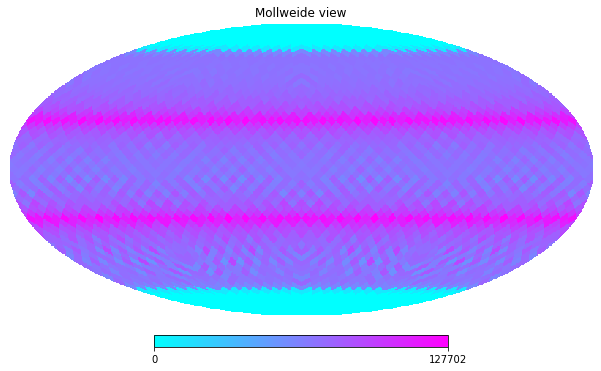

In [34]:
# Plot the map.  If we were running on multiple processes, then
# only rank zero would do this...

import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

hitdata = hp.read_map(hitsfile, nest=True)
hp.mollview(hitdata, xsize=800, nest=True, cmap="cool", min=0)
plt.show()
